### TP2.3 : états de marché

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

#### 1. Détermination d’états de marché
— Télécharger la trame de clustering avec Leiden pour le clustering par la méthode de Leiden. 
1. Charger les données de rendements US.

In [30]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sknetwork.clustering import Leiden
from scipy import sparse
from tqdm import tqdm

In [31]:
data = pd.read_parquet("sp500_20161229.parquet")
data.set_index("index", inplace=True)
data

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,...,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,...,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,...,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,...,NaN,0.001478,0.003753,0.001583,0.019615,0.019732,-0.006110,-0.002848,-0.005117,0.010422
2006-01-09,-0.002886,0.011255,0.004860,0.000000,0.037173,-0.015641,0.014073,-0.002581,-0.014676,-0.004816,...,NaN,-0.002362,-0.002671,0.006752,-0.000687,-0.000505,0.013661,0.007752,0.035415,-0.008277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.017029,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,-0.007700,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.015034,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138


2. Choisir une taille de fenêtre de calibration T.

In [32]:
T = 50 # Nombre de points dans la fenêtre de calibration

3. Choisir un univers de titres (colonnes). Rappel : pour la détermination des états de marché, N > T est
indispensable.

In [33]:
N = data.shape[1] # Taille de l'univers : pour le moment on prend tout
N

328

In [34]:
np.random.seed(42)
universe = sorted(np.random.choice(data.columns, N, replace=False))
df_universe = data[universe].copy()
df_universe

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,...,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,...,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,...,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,...,NaN,0.001478,0.003753,0.001583,0.019615,0.019732,-0.006110,-0.002848,-0.005117,0.010422
2006-01-09,-0.002886,0.011255,0.004860,0.000000,0.037173,-0.015641,0.014073,-0.002581,-0.014676,-0.004816,...,NaN,-0.002362,-0.002671,0.006752,-0.000687,-0.000505,0.013661,0.007752,0.035415,-0.008277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.017029,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,-0.007700,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.015034,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138


4. Pour chaque fenêtre de calibration :
- supprimez les colonnes avec des NA
- appliquer l’algorithme de Leiden selon la méthode de MacMahon et Garlaschelli pour obtenir les états
$\mu_t, t \in \{t_0,t_1, ..., T\}$, $n_p$ fois (e.g. $n_p$ = 20)

In [35]:
# On flag par fenêtre de calibration de taille T mais à l'envers
df_universe = df_universe.sort_index(ascending=False)
df_universe["calibration"] = (np.arange(df_universe.shape[0]) // T)
df_universe = df_universe.sort_index(ascending = True)
df_universe = df_universe[df_universe["calibration"] < df_universe["calibration"].max()]
df_universe

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,...,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION,calibration
index,,,,,,,,,,,,,,,,,,,,,
2006-03-09,-0.009573,0.001042,-0.022911,0.004367,-0.006670,-0.008999,-0.018479,0.014452,-0.015034,0.016450,...,0.008642,-0.004945,-0.012552,-0.005445,-0.013231,-0.002660,0.007194,-0.013915,-0.016342,61
2006-03-10,0.004695,0.014578,0.009908,-0.005217,0.016902,-0.006143,-0.008876,0.014034,-0.004737,0.007393,...,0.012138,0.004417,-0.004038,-0.009386,0.004413,0.002000,-0.004490,0.007873,0.012094,61
2006-03-13,0.015118,-0.004790,-0.014061,0.008523,0.022996,-0.001881,0.002442,-0.002516,0.000264,-0.001388,...,0.018623,0.011545,0.008241,0.007106,0.007773,0.005988,-0.007175,0.010464,0.002052,61
2006-03-14,-0.002437,0.017532,0.027861,0.004334,0.005119,0.007001,0.018138,-0.001261,0.014539,0.006554,...,0.008310,0.001630,0.011233,0.012936,0.019618,0.001984,0.011150,0.000146,0.006625,61
2006-03-15,0.018730,0.010135,-0.014843,0.013808,0.001993,-0.008556,0.010104,-0.011577,0.031527,-0.004736,...,0.009203,0.004883,0.013033,-0.006966,0.003453,0.009241,-0.004493,0.001750,0.001436,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.025323,-0.028534,-0.050340,-0.013690,-0.018889,-0.016213,-0.009486,-0.017686,-0.049520,0.016530,...,-0.006742,0.029647,-0.000712,-0.018732,-0.020152,-0.035985,-0.022026,-0.009216,-0.015853,0
2018-06-26,0.012745,0.034794,0.000530,-0.019844,0.000658,0.010723,0.005706,-0.011271,0.003237,0.004862,...,0.022342,0.003987,-0.000356,0.007636,0.011287,-0.004715,0.018068,0.016527,-0.010983,0
2018-06-27,-0.013553,-0.001310,-0.031391,-0.006306,-0.005262,-0.018865,-0.022389,-0.014953,-0.019590,0.009176,...,-0.014385,0.007942,-0.002674,-0.022583,0.013269,-0.032373,-0.014248,-0.022210,-0.018138,0


Maintenant complétons le code de l'algorithme de Leiden. 

In [36]:
def compute_filtered_C(R):
    C = np.corrcoef(R, rowvar=False)
    q = T/N
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_, v = LA.eigh(C)
    lambda_filtered = np.where(lambda_ > lambda_plus, lambda_, 0)
    C_s = np.dot(v, np.dot(np.diag(lambda_filtered), v.T))
    return C_s

def LeidenCorrelationClustering(C_s):   # C_s is the filtered correlation matrix

    # Ensure the positivity of the filtered correlation matrix
    C_s = np.abs(C_s)

    adjacency = sparse.csr_matrix(C_s)   # C_s is not sparse but it is the only current format that works for now.

    leiden = Leiden()
    labels = leiden.fit_predict(adjacency)

    return labels

In [37]:
mu_array = np.zeros(T)

In [38]:

def process(df):
    mu_array = []
    for i in tqdm(range(np.max(df["calibration"])+1)):
        df_i=df[df["calibration"]==i]
        df_i=df_i.drop(columns=["calibration"])
        df_i = df_i.dropna(axis=1)
        C_s = compute_filtered_C(df_i)
        mu = LeidenCorrelationClustering(C_s)
        mu_array.append(mu)
    return mu_array

states = process(df_universe)

100%|██████████| 62/62 [00:05<00:00, 10.70it/s]


In [39]:
print(len(states))

62




5. Tracez le nombre d’états de marché en fonction du temps.

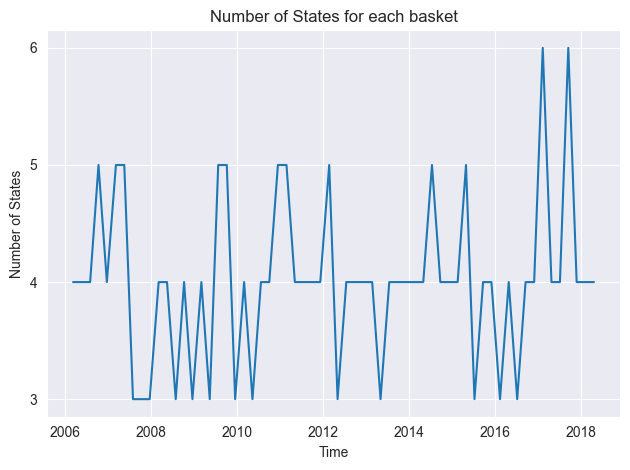

In [40]:
from matplotlib.ticker import MaxNLocator

times = []
nb_states = []
for i in range(len(states)):
    times.append(df_universe[df_universe["calibration"] == i].index[0])
    nb_states.append(max(states[i]) + 1)

plt.plot(times, nb_states)
plt.title("Number of States for each basket")
plt.xlabel("Time")
plt.ylabel("Number of States")

# Ensure y-axis shows only integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
def choose_best_cluster_assets(df, states):
    selected_assets_per_window = []

    for window_idx, labels in enumerate(states):
        # Filter data for the current window
        window_data = df[df["calibration"] == window_idx].drop(columns=["calibration"]).dropna(axis=1)
        assets = window_data.columns
        
        # Check dimensions match
        if len(labels) != len(assets):
            continue

        # Compute mean returns per asset in this window
        mean_returns = window_data.mean()

        # Compute mean returns per cluster
        cluster_perf = {}
        for label in np.unique(labels):
            cluster_assets = assets[labels == label]
            cluster_mean_return = mean_returns[cluster_assets].mean()
            cluster_perf[label] = cluster_mean_return

        # Identify best-performing cluster
        best_cluster = max(cluster_perf, key=cluster_perf.get)

        # Select assets from best-performing cluster
        selected_assets = list(assets[labels == best_cluster])
        selected_assets_per_window.append({
            'window': window_idx,
            'best_cluster': best_cluster,
            'assets': selected_assets
        })

    return selected_assets_per_window

In [42]:
# Apply this strategy criterion
selected_assets_strategy = choose_best_cluster_assets(df_universe, states)

# Example output (first calibration window)
selected_assets_strategy[0]

{'window': 0,
 'best_cluster': np.int64(2),
 'assets': ['AA',
  'AEE',
  'AEP',
  'AES',
  'ALTR',
  'APA',
  'ASH',
  'ATI',
  'AVP',
  'BTU',
  'CBH',
  'CHK',
  'CIEN',
  'CMS',
  'CNP',
  'CNX',
  'COP',
  'CVX',
  'D',
  'DF',
  'DRI',
  'DTE',
  'DTV',
  'DUK',
  'DVN',
  'ED',
  'EIX',
  'EOG',
  'ETR',
  'EXC',
  'FE',
  'GEC',
  'GNW',
  'GPS',
  'HAL',
  'HES',
  'ITT',
  'JBL',
  'LUV',
  'MCD',
  'MRO',
  'MTG',
  'MUR',
  'NBR',
  'NE',
  'NEE',
  'NI',
  'NOV',
  'NUE',
  'NYT',
  'OXY',
  'PCG',
  'PEG',
  'PNW',
  'PPL',
  'RDC',
  'RIG',
  'SO',
  'SRE',
  'SUN',
  'THC',
  'TXT',
  'VLO',
  'WFT',
  'WMB',
  'XEL',
  'XOM']}

In [43]:
def rolling_window_strategy(df, window_size=T):
    daily_returns = []
    df = df.sort_index()

    for start in tqdm(range(len(df) - window_size - 1)):
        end = start + window_size

        # Window data
        window_data = df.iloc[start:end].dropna(axis=1, how='any')
        next_day_returns = df.iloc[end + 1]

        if window_data.shape[1] == 0:
            continue

        # Clustering
        C_s = compute_filtered_C(window_data.values)
        labels = LeidenCorrelationClustering(C_s)

        # Identify best-performing cluster
        mean_returns = window_data.mean()
        assets = window_data.columns
        cluster_perf = {}
        for label in np.unique(labels):
            cluster_assets = assets[labels == label]
            cluster_perf[label] = mean_returns[cluster_assets].mean()

        best_cluster = max(cluster_perf, key=cluster_perf.get)
        best_assets = assets[labels == best_cluster]

        portfolio_return = next_day_returns[best_assets].mean()
        daily_returns.append(portfolio_return)

    return daily_returns

In [44]:
# Execute rolling window strategy
daily_strategy_returns = rolling_window_strategy(df_universe.drop(columns=["calibration"]))

# Quick check of first few returns
print(daily_strategy_returns[:5])

100%|██████████| 3049/3049 [03:04<00:00, 16.55it/s]

[np.float64(-0.010171366849222535), np.float64(0.0028154714588926296), np.float64(-0.0069250258520019495), np.float64(0.019645224339396604), np.float64(0.008666195858470858)]


In [45]:
def compute_performance_metrics(returns):
    returns = np.array(returns)
    cumulative_return = np.prod(1 + returns) - 1
    annualized_return = np.mean(returns) * 252
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    
    performance = {
        'cumulative_return': cumulative_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio
    }
    
    return performance

In [46]:
# Compute strategy performance metrics
performance = compute_performance_metrics(daily_strategy_returns)

# Display results
print(performance)


{'cumulative_return': np.float64(1.4121142291755282), 'annualized_return': np.float64(0.1021164688045701), 'annualized_volatility': np.float64(0.2416501143893531), 'sharpe_ratio': np.float64(0.4225798488141302)}


In [48]:
def plot_cumulative_returns(returns, df, window_size=T):
    returns = np.array(returns)
    cumulative_returns = np.cumprod(1 + returns)

    # Generate correct date index (1 day after each window ends)
    dates = df.index[window_size + 1 : window_size + 1 + len(returns)]

    plt.figure(figsize=(12, 5))
    plt.plot(dates, cumulative_returns, label="Strategy")
    plt.title("Cumulative Performance of rolling window Strategy")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

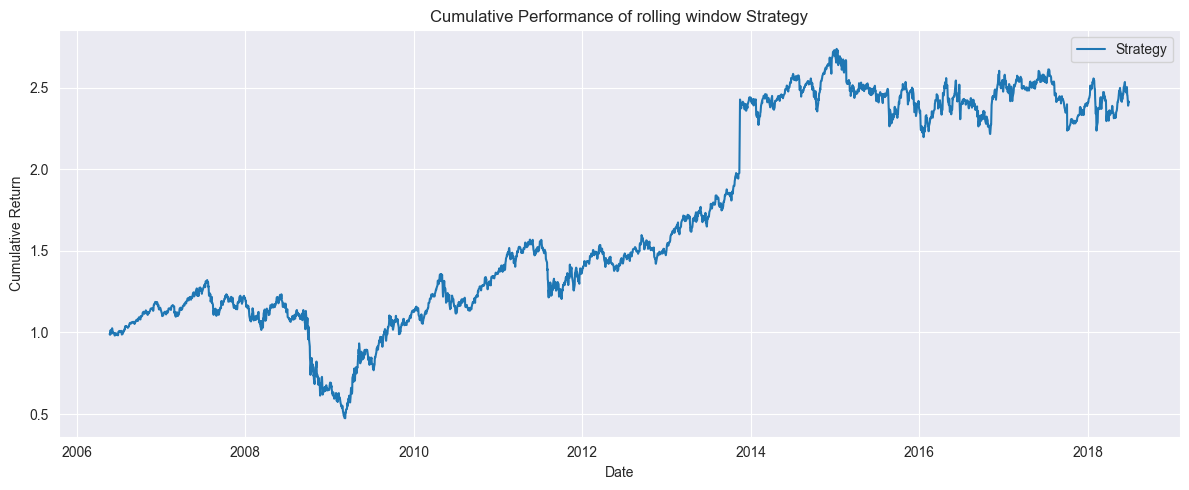

In [49]:
# Plot the equity curve
plot_cumulative_returns(daily_strategy_returns, df_universe)